# Predição de Atraso em Linhas Áereas

O dataset estudado foi obtido na plataforma [Kaggle](https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay), contendo métricas de vôos, companhias áreas, tipo da aeronave e etc.

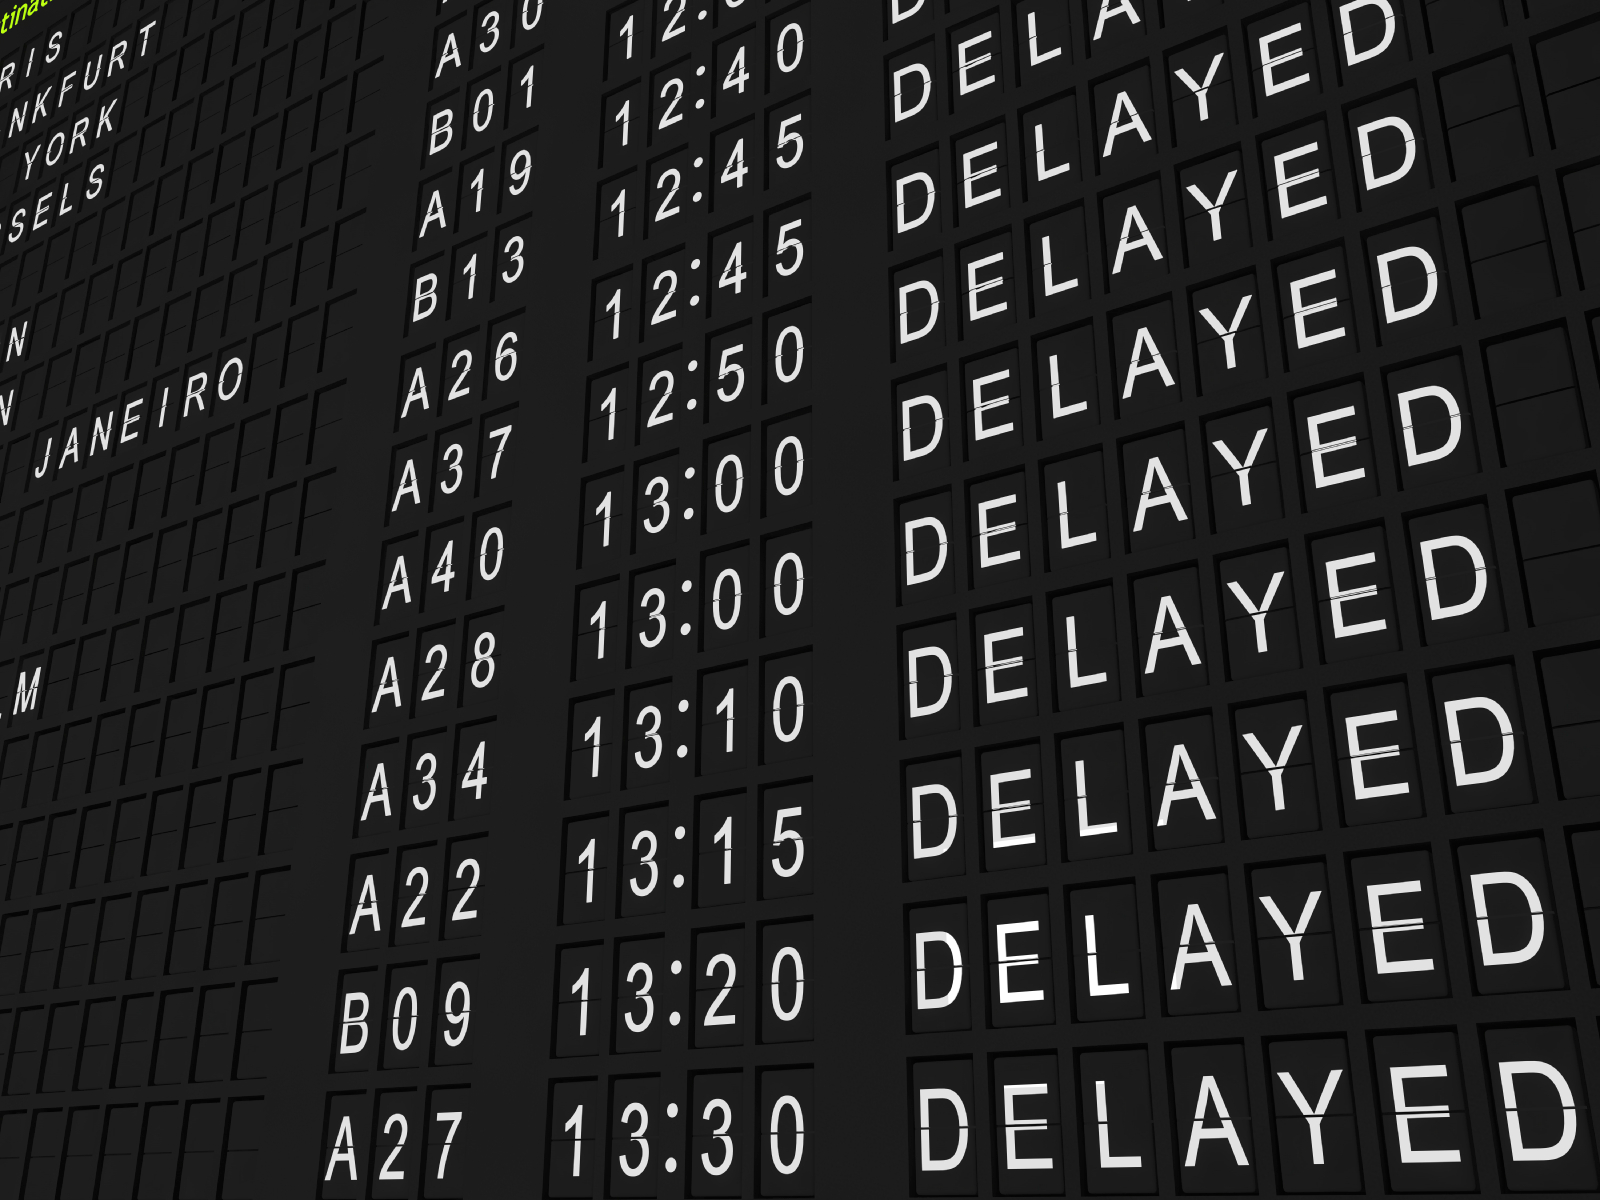

Grande impacto socieecônomico:
- Insatisfação do cliente
  - Perda de confiança na companhia
- Prejuízo ecônomico
- Realocações de vôo (overbooking)

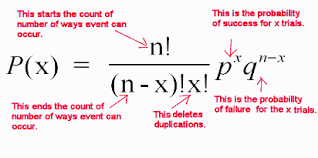

- Intervenção logística

### Célula de import
**Disclaimer**: faça o dump de imports aqui

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Função para plotar ROC e Matriz de Confusão

Não sei o que faz, roubei do Emanuel e não me arrependo.

In [ ]:
"""
Plot metrics
"""
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def multiclass_roc(y_score, y_test, n_classes, classes, ax):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], classes[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()

def plot_metrics(model, X_test,y_test):
  fig, [ax_roc, ax] = plt.subplots(1,2, figsize=(20, 10))
  preds = model.predict(X_test)
  n_classes = model.classes_.shape[0]
  classes = model.classes_
  y_scores = model.predict_proba(X_test)
  score = model.score(X_test,y_test)
  # print(score)
  # ax_scores.plot(score)
  # ax_scores.set_xlabel('Num of score');ax_scores.set_ylabel('Score'); 
  # ax_scores.set_title('cross_val_score'); 
  # plt.show()
  multiclass_roc(y_scores, y_test, n_classes, classes, ax_roc)
  C = confusion_matrix(y_test, preds)
  cm = C / C.astype(float).sum(axis=1)
  # ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(["True","False"]); ax.yaxis.set_ticklabels(["True","False"]);
  
  f1 = f1_score(y_test, preds, average="micro")
  acc = accuracy_score(y_test, preds)
  print(f"F1 Score averega Micro: {f1} \n accuracy: {acc}")
  plt.legend()
  plt.show()

### Iniciando o datase
Copiando o csv para um Dataset (ao realizar filtros e manutenções, utilizar cópia).

In [ ]:
dataset_unfiltered = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Datasets/Airline Delay/Airlines.csv",
    index_col=False,
    sep=',',
    header = 0
    )
dataset_unfiltered

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


### Filtrando e limpando o dataset
Removendo entradas sem ano de lançamento

In [ ]:
df = dataset_unfiltered
df = df.drop(axis=1,columns=['id'])
print(df.dtypes)

Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object


### Verificando a distribuição de classes

In [ ]:
dataset_unfiltered['Delay'].value_counts()

0    299119
1    240264
Name: Delay, dtype: int64

In [ ]:
print("Razão FALSE: " + str(299119/len(dataset_unfiltered)))
print("Razão TRUE: " + str(240264/len(dataset_unfiltered)))

Razão FALSE: 0.5545577076029463
Razão TRUE: 0.4454422923970537


### Transformando os dados em inteiros

As colunas Airline (companhia áerea), AirportFrom (Sigla do aeroporto de origem) e AirportTo (Sigla do aeroporto de destino).

In [ ]:
for col in df:
  if col in df.columns[-2:]:
    break
  if df[col].dtype == 'object':
    for id, val in enumerate(df[col].unique()):
      df[col].iloc[df[col] == val] = id

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Cópia do dataset corrigido

In [ ]:
df.head(20).style

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,0,269,0,0,3,15,205,1
1,1,1558,1,1,3,15,222,1
2,2,2400,2,2,3,20,165,1
3,2,2466,0,2,3,20,195,1
4,3,108,3,3,3,30,202,0
5,0,1094,2,0,3,30,181,1
6,4,1768,2,4,3,30,220,0
7,4,2722,1,5,3,30,228,0
8,4,2606,0,4,3,35,216,1
9,2,2538,4,6,3,40,200,1


---

# Implementando os algoritmos

### Montando o Dataset para treino dos modelos

Características observadas (colunas 1 a 8)

In [ ]:
df_caracteristicas = df[df.columns[:-2]]

Classe prevista (coluna 9 - Atraso)

In [ ]:
df_classe = df['Delay']

Divisão do dataset em treinos, testes e validadores

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_caracteristicas, df_classe, test_size=0.3)

# Criando Array de Models

In [ ]:
models = []
seed = 7

## KNN

Determinando o K

In [ ]:
Def_K = 9
print("K determinado:", Def_K)

K determinado: 9


In [ ]:
KNN = KNeighborsClassifier(n_neighbors=Def_K)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [ ]:
KNN.predict(X_test)

array([0, 0, 1, ..., 0, 1, 0])

No handles with labels found to put in legend.


F1 Score averega Micro: 0.6490313011772704 
 accuracy: 0.6490313011772704


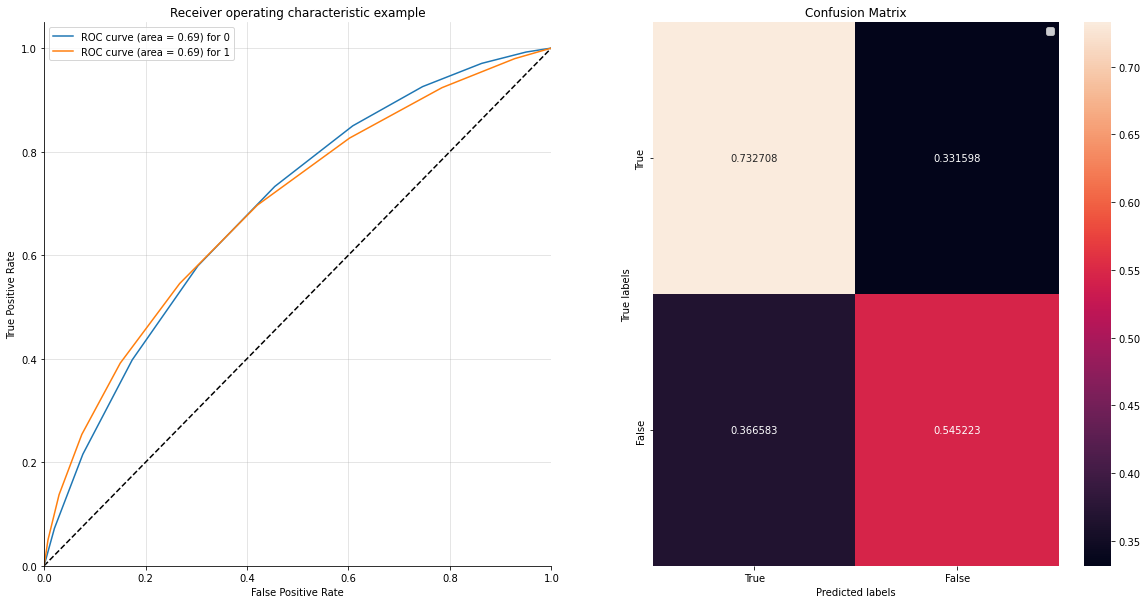

In [ ]:
plot_metrics(KNN, X_test, y_test)

In [ ]:
models.append(('KNN', KNN))

## Random Forest

In [ ]:
RDF=RandomForestClassifier(n_estimators=90)
RDF.fit(X_train,y_train)

RandomForestClassifier(n_estimators=90)

In [ ]:
RDF.predict(X_test)

array([0, 1, 0, ..., 0, 1, 0])

No handles with labels found to put in legend.


F1 Score averega Micro: 0.620653215091308 
 accuracy: 0.620653215091308


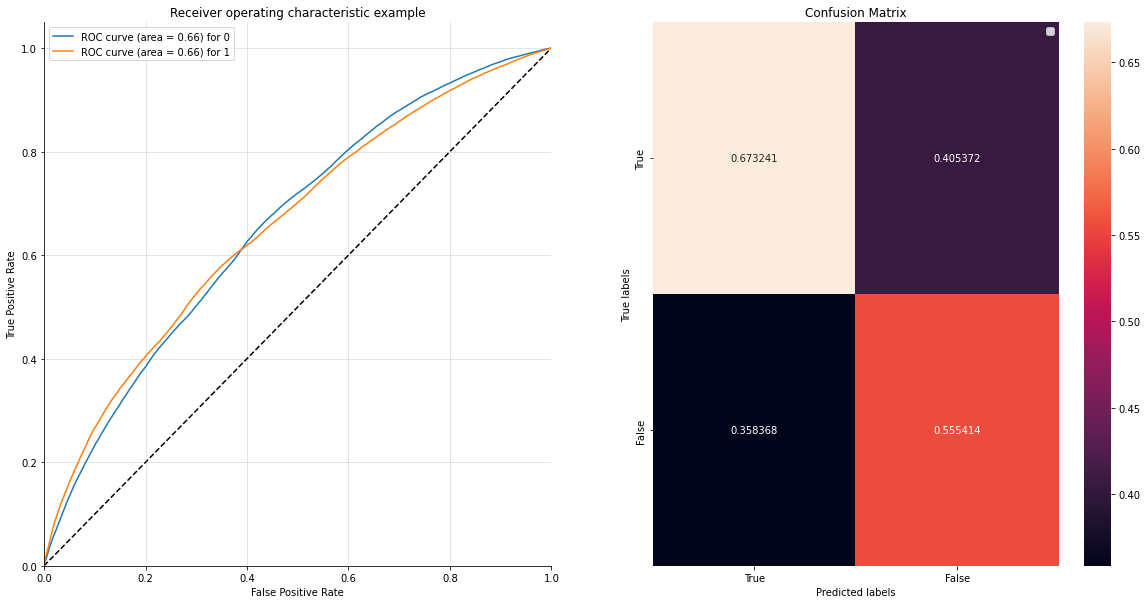

In [ ]:
plot_metrics(RDF, X_test, y_test)

In [ ]:
models.append(('Random Forest', RDF))

## Naive Bayes

In [ ]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)

GaussianNB()

In [ ]:
GNB.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

No handles with labels found to put in legend.


F1 Score averega Micro: 0.6009269845193586 
 accuracy: 0.6009269845193586


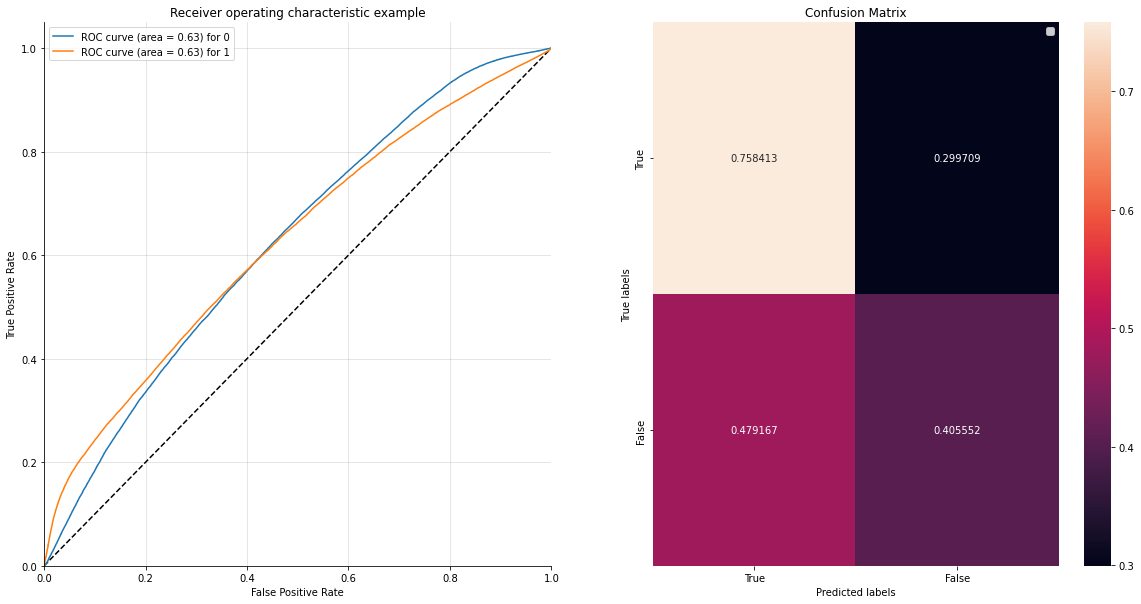

In [ ]:
plot_metrics(GNB, X_test, y_test)

In [ ]:
models.append(('Naive Bayes', GNB))

## Comparandos os Modelos

Iterando pela lista de algoritmos

In [ ]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

KNN: 0.618694 (0.002958)
Random Forest: 0.617878 (0.004679)
Naive Bayes: 0.600198 (0.003147)


Plot Gráfica dos Comparativos

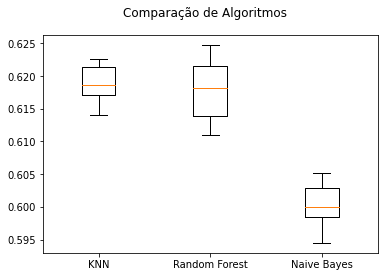

In [ ]:
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

---

## Compreendendo o resultado

- Distâncoa
 - grande quantidade de dados
 - grande quantidade de dimensões
- Dados categóricos binários (0 e 1)
- Regularização da regtessão logística
- Sensibilidade à outliers

### Glória a RDF

- Versatilidade (regressão e classificação)
- Redução de overfit


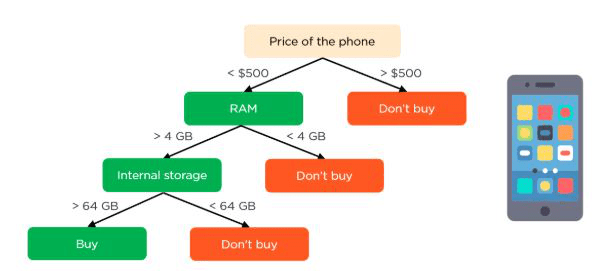